In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rocks
rocks.set_log_level("error")
import time as t

In [2]:
# DAMIT
# path_damit = '/astrodata/Catalog/DAMIT/damit20230418/'
path_data = os.path.join('..','data')
path_damit = os.path.join(path_data,'damit')
path_spins = './'

# Read data

In [3]:
# Read DAMIT Tables
ssos = pd.read_csv(os.path.join( path_damit, 'damit-asteroids.csv'))
models = pd.read_csv(os.path.join( path_damit, 'damit-asteroid_models.csv'))
refs = pd.read_csv(os.path.join( path_damit, 'damit-asteroid_models_references.csv'))
bibs = pd.read_csv(os.path.join( path_damit, 'damit-references.csv'))

In [4]:
# Select columns for ASTEROIDS
ssos = ssos[ ['id', 'number', 'name', 'designation'] ]
ssos.columns = ['asteroid_id', 'number', 'name', 'designation']

In [5]:
# Select columns for MODELS
models = models[ [ 'id', 'asteroid_id', 'lambda', 'beta', 'period' ] ]
models.columns = [ 'model_id', 'asteroid_id', 'lambda', 'beta', 'period' ]

In [6]:
# Select columns for REFERENCES
refs = refs[ ['asteroid_model_id','reference_id'] ]
refs.columns = ['model_id','reference_id']

In [7]:
# Select columns for BIBLIOGRAPHY
bibs = bibs[ ['id', 'bibcode'] ]
bibs.columns = ['reference_id', 'bibcode']

In [8]:
# Merge everything
data = models.merge( ssos, on='asteroid_id')
data = data.merge( refs, on='model_id')
data = data.merge( bibs, on='reference_id')
data

,model_id,asteroid_id,lambda,beta,period,number,name,designation,reference_id,bibcode
0,101,101,35.0,-12.0,7.813230,2.0,Pallas,NaN,106,2003icar..164..346t
1,106,104,340.0,42.0,7.274471,6.0,Hebe,NaN,106,2003icar..164..346t
2,110,106,335.0,-5.0,12.866670,8.0,Flora,NaN,106,2003icar..164..346t
3,111,107,180.0,22.0,5.079176,9.0,Metis,NaN,106,2003icar..164..346t
4,117,111,98.0,57.0,7.443224,19.0,Fortuna,NaN,106,2003icar..164..346t
...,...,...,...,...,...,...,...,...,...,...
16312,16275,10853,326.0,-83.0,8.016800,99949.0,Miepgies,NaN,665,2023arxiv230510798d
16313,16276,10854,34.0,-42.0,143.500000,99973.0,NaN,NaN,665,2023arxiv230510798d
16314,16277,10854,194.0,-64.0,143.490000,99973.0,NaN,NaN,665,2023arxiv230510798d
16315,16278,10855,192.0,-52.0,7.071400,99990.0,NaN,NaN,665,2023arxiv230510798d


In [9]:
data[ data.number==2 ]
# data[ data.number==135 ]

,model_id,asteroid_id,lambda,beta,period,number,name,designation,reference_id,bibcode
0,101,101,35.0,-12.0,7.81323,2.0,Pallas,NaN,106,2003icar..164..346t
24,101,101,35.0,-12.0,7.81323,2.0,Pallas,NaN,139,2011icar..214..652d
75,102,101,32.0,-11.0,7.81322,2.0,Pallas,NaN,169,2017a&a...601a.114h
116,102,101,32.0,-11.0,7.81322,2.0,Pallas,NaN,132,2010icar..205..460c


# Compute R

In [10]:
abc = pd.read_csv( os.path.join(path_damit, 'abc.csv') )

# Revert b and c if needed 
cond_bc = abc['b'] < abc['c']
print('revert bc', len(abc[cond_bc]))

b = abc.loc[cond_bc,'b']
abc.loc[cond_bc,'b'] = abc.loc[cond_bc,'c']
abc.loc[cond_bc,'c'] = b

# Revert a and b if needed 
cond_ab = abc['a'] < abc['b']
print('revert ab', len(abc[cond_ab]))

a = abc.loc[cond_ab,'a']
abc.loc[cond_ab,'a'] = abc.loc[cond_ab,'b']
abc.loc[cond_ab,'b'] = a


# Revert b and c again if needed 
cond_bc = abc['b'] < abc['c']
print('revert bc', len(abc[cond_bc]))

b = abc.loc[cond_bc,'b']
abc.loc[cond_bc,'b'] = abc.loc[cond_bc,'c']
abc.loc[cond_bc,'c'] = b

# Check
cond_bc = abc['b'] < abc['c']
cond_ab = abc['a'] < abc['b']
print('miss ab, bc', len(abc[cond_ab]), len(abc[cond_bc]))

# abc[cond_bc]

revert bc 0
revert ab 0
revert bc 0
miss ab, bc 0 0


In [11]:
# Old computation 
# abc['R'] = abc['c']*(abc['a']+abc['b']) / (2 * abc['a']* abc['b'])

In [13]:
(abc.R-abc.R2).max()

1.6605438733940936e-05

In [14]:
all = data.merge( abc, on='model_id')
len(data), len(abc), len(all)

(16317, 16073, 16317)

In [15]:
all.to_csv( os.path.join(path_data, 'damit_abc.csv'), index=False)

In [14]:
all['R'].mean()

0.709146330721016

# Plot!

Text(0, 0.5, 'a/c')

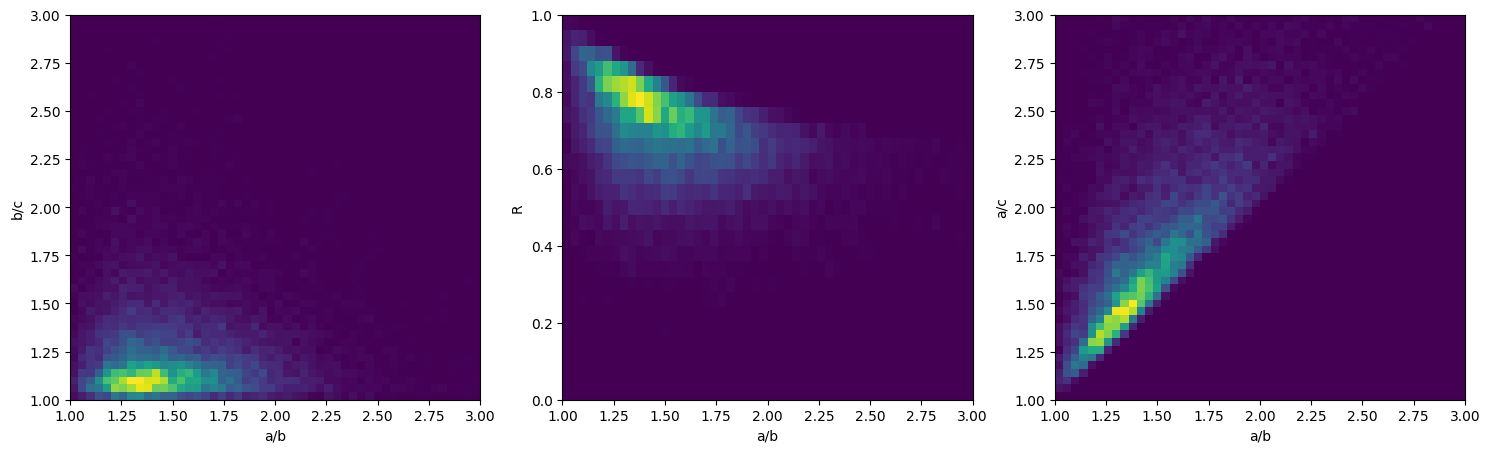

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))


r_ab = [1,3]
r_bc = [1,3]
r_ac = [1,3]
r_R = [0,1]
b_ab = 50
b_bc = 50
b_ac = 50
b_R = 25

# --------------------------------------------------------------------------------
# ab vs bc
ax[0].hist2d( abc['a']/abc['b'], abc['b']/abc['c'], range=[r_ab,r_bc], bins=[b_ab,b_bc] )

# --------------------------------------------------------------------------------
# ab vs R
ax[1].hist2d( abc['a']/abc['b'], abc['R'], range=[r_ab,r_R], bins=[b_ab,b_R] )

# --------------------------------------------------------------------------------
# ab vs ac
ax[2].hist2d( abc['a']/abc['b'], abc['a']/abc['c'], range=[r_ab,r_ac], bins=[b_ab,b_ac] )


# --------------------------------------------------------------------------------
# ab vs R
ax[0].set_xlabel('a/b')
ax[0].set_ylabel('b/c')

ax[1].set_xlabel('a/b')
ax[1].set_ylabel('R')

ax[2].set_xlabel('a/b')
ax[2].set_ylabel('a/c')

# ax.legend(loc='upper left')

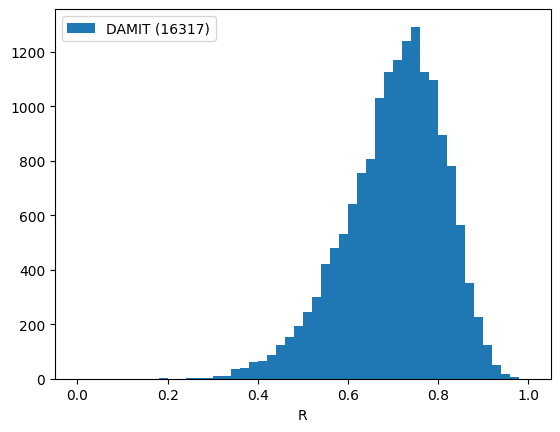

In [17]:
fig, ax = plt.subplots()

r = [0,1]
b = 50
ax.hist( abc.R, range=r, bins=b, label=f'DAMIT ({len(data)})' )
# ax.hist( data.R2, range=r, bins=b, label=f'DAMIT ({len(data)})' )
ax.set_xlabel('R')
ax.legend(loc='upper left')

In [ ]:
data.bibcode.value_counts().head(50)

In [ ]:
[str(a).upper() for a in data.bibcode.value_counts().head(20).index]

In [ ]:
data